In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import commonutils
import models

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

from dataclasses import dataclass
import prettyprinter as pp

from sklearn.cross_decomposition import PLSRegression
import warnings
import sys

from sklearn import preprocessing

from copy import deepcopy

In [2]:
warnings.simplefilter("ignore")

supersetnames = {"BARRIER_HEIGHTS" : \
                       ["BH76","BHDIV10","BHPERI",\
                        "BHROT27","INV24","PX13","WCPT18"] \
                    ,"INTRAMOLECULAR_INTERACTIONS" : \
                       ["ACONF",'Amino20x4',"BUT14DIOL",\
                        "ICONF","IDISP","MCONF",\
                        "PCONF21","SCONF","UPU23"] , \
                    "SMALL_MOLECULES" :\
                        ["AL2X6","ALK8","ALKBDE10","BH76RC",\
                         "DC13","DIPCS10","FH51","G21EA",\
                         "G21IP","G2RC","HEAVYSB11","NBPRC",\
                         "PA26","RC21","SIE4x4","TAUT15",\
                         "W4-11","YBDE18"], \
                    "INTERMOLECULAR_INTERACTIONS" :\
                       ["ADIM6","AHB21","CARBHB12",\
                        "CHB6","HAL59","HEAVY28","IL16",\
                        "PNICO23","RG18","S22","S66","WATER27"] , \
                    "LARGE_SYSTEMS" :\
                        ["BSR36","C60ISO","CDIE20","DARC",\
                         "ISO34","ISOL24","MB16-43","PArel",\
                            "RSE43"]}  

howmanydifs = 3
methods = {}
entries = ["Nuclear Repulsion  :", \
        "One Electron Energy:", \
        "Two Electron Energy:", \
        "Potential Energy   :", \
        "Kinetic Energy     :", \
        "E(X)               :"  , \
        "E(C)               :"  , \
        "Dispersion correction", \
        "FINAL SINGLE POINT ENERGY"]
functionals = ["PBE", "PBE0", "TPSS", "TPSSh"]
basis_sets = ["MINIX", "SVP", "TZVP"]
for func in functionals:
    for basis in basis_sets:
        methods[func + "-" + basis] = []
        for ebtry in entries:
            methods[func + "-" + basis].append(ebtry)

# read all the data and initialize the data structures
rootdir = "../datasets/AllData_3/"   
allvalues_perset, fullsetnames, models_results = \
        commonutils.read_and_init (rootdir, supersetnames, howmanydifs, methods, \
                       DEBUG=True)

Reading dataset:  BH76
Number of samples:  76
Number of basic descriptors:  76

Reading dataset:  BHDIV10
Number of samples:  10
Number of basic descriptors:  10

Reading dataset:  BHPERI
Number of samples:  26
Number of basic descriptors:  26

Reading dataset:  BHROT27
Number of samples:  27
Number of basic descriptors:  27

Reading dataset:  INV24
Number of samples:  24
Number of basic descriptors:  24

Reading dataset:  PX13
Number of samples:  13
Number of basic descriptors:  13

Reading dataset:  WCPT18
Number of samples:  18
Number of basic descriptors:  18

Reading dataset:  ACONF
Number of samples:  15
Number of basic descriptors:  15

Reading dataset:  Amino20x4
Number of samples:  80
Number of basic descriptors:  80

Reading dataset:  BUT14DIOL
Number of samples:  64
Number of basic descriptors:  64

Reading dataset:  ICONF
Number of samples:  17
Number of basic descriptors:  17

Reading dataset:  IDISP
Number of samples:  6
Number of basic descriptors:  6

Reading dataset:  

In [3]:
# for debug purposes
#for val in allvalues_perset:
#    print("======= START =======")
#    print(val, len(allvalues_perset[val]))
#    pp.pprint(allvalues_perset[val])
#    print("=======  END  =======")

In [4]:
from commonutils import ModelResults

allfeatures = set()
for setname in fullsetnames:
    for val in allvalues_perset[setname]:
        for k in val:
            if k.find("energydiff") != -1:
                for f in val[k]:
                    allfeatures.add(f)

# set labels and sets iists
models_results = {}
for setname in fullsetnames:
    models_results[setname] = ModelResults()
    for val in allvalues_perset[setname]:
        models_results[setname].labels.append(val["label"]) 
        models_results[setname].supersetnames.append(val["super_setname"])
        models_results[setname].setnames.append(val["super_setname"]+"_"+val["setname"])

for setname in fullsetnames:
    for methodid in range(howmanydifs):
        y_pred = []
        for val in allvalues_perset[setname]:
            y_pred.append(val["label"] + val["difs"][methodid])

        wtmad = commonutils.wtmad_calc(models_results[setname].supersetnames,\
                                    models_results[setname].setnames, y_pred, \
                                    models_results[setname].labels, includeFull = True)
        
        if wtmad["Full"] < models_results[setname].bestinsidemethod_wtamd:
            models_results[setname].bestinsidemethod_wtamd = wtmad["Full"]
            models_results[setname].bestinsidemethod_name_wtamd = str(methodid)
            models_results[setname].y_pred_bestinsidemethod_wtamd = y_pred

        rmse = mean_squared_error(models_results[setname].labels, \
                                y_pred, squared=False)

        if rmse < models_results[setname].bestinsidemethod_rmse:
            models_results[setname].bestinsidemethod_rmse = rmse
            models_results[setname].bestinsidemethod_name_rmse = str(methodid)
            models_results[setname].y_pred_bestinsidemethod_rmse = y_pred

    for j, method in enumerate(methods):
        y_pred = []
        for val in allvalues_perset[setname]:
            y_pred.append(val[method + "_energydiff"][method+"_FINAL_SINGLE_POINT_ENERGY"])

        wtmad = commonutils.wtmad_calc(models_results[setname].supersetnames, \
                                models_results[setname].setnames, y_pred, \
                                models_results[setname].labels, includeFull = True)

        if wtmad["Full"] < models_results[setname].bestourmethod_wtamd:
            models_results[setname].bestourmethod_wtamd = wtmad["Full"] 
            models_results[setname].bestourmethod_name_wtamd = method
            models_results[setname].y_pred_bestourmethod_wtamd = y_pred
        
        rmse = mean_squared_error(models_results[setname].labels,\
                                y_pred, squared=False)

        if rmse < models_results[setname].bestourmethod_rmse:
            models_results[setname].bestourmethod_rmse = rmse
            models_results[setname].bestourmethod_name_rmse = method
            models_results[setname].y_pred_bestourmethod_rmse = y_pred

print("Results for inside and our methods")
print("%40s"% "Dataset", " , ", \
    "Best inside method RMSE", " , ", \
    "RMSE", " , ", \
    "Best inside method WTAMD", " , ", \
    "WTAMD", " , ", \
    "Best our method RMSE", " , ", \
    "RMSE", " , ", \
    "Best our method WTAMD", " , ", \
    "WTAMD")
for setname in fullsetnames:
    print("%40s"%setname, " , ", \
        "%10s"%models_results[setname].bestinsidemethod_name_rmse , " , ",\
        "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
        "%10s"%models_results[setname].bestinsidemethod_name_wtamd , " , ", \
        "%7.3f"%models_results[setname].bestinsidemethod_wtamd, " , ", \
        "%10s"%models_results[setname].bestourmethod_name_rmse , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
        "%10s"%models_results[setname].bestourmethod_name_wtamd , " , ", \
        "%7.3f"%models_results[setname].bestourmethod_wtamd)

Results for inside and our methods
                                 Dataset  ,  Best inside method RMSE  ,  RMSE  ,  Best inside method WTAMD  ,  WTAMD  ,  Best our method RMSE  ,  RMSE  ,  Best our method WTAMD  ,  WTAMD
                         BARRIER_HEIGHTS  ,           0  ,    8.201  ,           0  ,    8.040  ,   PBE0-TZVP  ,    4.856  ,   PBE0-TZVP  ,    4.970
                    BARRIER_HEIGHTS_BH76  ,           0  ,   10.387  ,           0  ,    9.150  ,   PBE0-TZVP  ,    5.505  ,   PBE0-TZVP  ,    5.000
                 BARRIER_HEIGHTS_BHDIV10  ,           0  ,    9.191  ,           0  ,    8.250  ,   PBE0-TZVP  ,    5.278  ,   PBE0-TZVP  ,    4.800
                  BARRIER_HEIGHTS_BHPERI  ,           0  ,    4.407  ,           0  ,    3.950  ,   PBE0-TZVP  ,    3.762  ,   PBE0-TZVP  ,    3.510
                 BARRIER_HEIGHTS_BHROT27  ,           1  ,    0.611  ,           1  ,    0.420  ,    PBE-TZVP  ,    0.718  ,    PBE-TZVP  ,    0.540
                   BARRIER_HEIGHT

In [5]:
#build descriptors 
selected_basisset = "TZVP"
selected_functional = "PBE"
functionals = ["PBE", "PBE0", "TPSS", "TPSSh"]
for setname in fullsetnames:
    desciptors = {}
    for val in allvalues_perset[setname]:
        for func in functionals:
            for basis in basis_sets:
                if basis == selected_basisset and func == selected_functional:
                    k = func + "-" + basis + "_energydiff"
                    for k2 in val[k]:
                        if k2 not in desciptors:
                            desciptors[k2] = [val[k][k2]]
                        else:
                            desciptors[k2].append(val[k][k2])
                else:
                    refk  = func + "-" + selected_basisset + "_energydiff"
                    k = func + "-" + basis + "_energydiff"
                    for k2 in val[k]:
                        refk2 = k2.replace(basis, selected_basisset)
                        newk2 = k2 + "_diffroref"
                        if newk2 not in desciptors:
                            desciptors[newk2] = [val[refk][refk2] - val[k][k2]]
                        else:
                            desciptors[newk2].append(val[refk][refk2] - val[k][k2])
    models_results[setname].features = desciptors
    #print("Descriptors for ", setname)
    #for k in desciptors:
    #    print(k, len(desciptors[k]), desciptors[k])

# remove constant values
for setname in fullsetnames:
    print("Removing constant features for ", setname)
    toremove = []
    for k in models_results[setname].features:
        if len(set(models_results[setname].features[k])) == 1:
            toremove.append(k)
    for k in toremove:
        print("Constant fatures to remove: ", k)
        del models_results[setname].features[k]

# test print for debug
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    for k in models_results[setname].features:
#        print(k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])

# force removing features Nuclear Repulsion difference
for setname in fullsetnames: 
    toremove = []
    for k in models_results[setname].features:
        if k.find("Nuclear_Repulsion_diffroref") != -1:
            toremove.append(k)
    for k in toremove:
        print("Removing feature ", k)
        del models_results[setname].features[k]


Removing constant features for  BARRIER_HEIGHTS
Constant fatures to remove:  PBE-MINIX_Nuclear_Repulsion_diffroref
Constant fatures to remove:  PBE-MINIX_Dispersion_correction_diffroref
Constant fatures to remove:  PBE-SVP_Nuclear_Repulsion_diffroref
Constant fatures to remove:  PBE-SVP_Dispersion_correction_diffroref
Constant fatures to remove:  PBE0-MINIX_Nuclear_Repulsion_diffroref
Constant fatures to remove:  PBE0-MINIX_Dispersion_correction_diffroref
Constant fatures to remove:  PBE0-SVP_Nuclear_Repulsion_diffroref
Constant fatures to remove:  PBE0-SVP_Dispersion_correction_diffroref
Constant fatures to remove:  PBE0-TZVP_Kinetic_Energy_diffroref
Constant fatures to remove:  PBE0-TZVP_Dispersion_correction_diffroref
Constant fatures to remove:  PBE0-TZVP_E(C)_diffroref
Constant fatures to remove:  PBE0-TZVP_Potential_Energy_diffroref
Constant fatures to remove:  PBE0-TZVP_FINAL_SINGLE_POINT_ENERGY_diffroref
Constant fatures to remove:  PBE0-TZVP_One_Electron_Energy_diffroref
Const

In [6]:
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    for k in models_results[setname].features:
#        print(k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])

In [7]:
# remove corralted features 
CORRCUT = 0.95

setname = "Full"
touse = []
toremove = []
df = pd.DataFrame(models_results[setname].features)
corr = df.corr().abs()
for i, k in enumerate(corr.columns):
    print(k, " ", i)
    touse.append(k)
    for idx, v in enumerate(corr[k]):
        if v > CORRCUT and idx < i:
            print(" %60s %4.2f"%(corr.index[idx], v))
            toremove.append(corr.index[idx])

print("Features to use")
for i, feat in enumerate(touse):
    print(i+1 ,  " - " , feat)

for setname in fullsetnames:
    for k in touse:
        models_results[setname].uncorrelated_features[k] = \
            deepcopy(models_results[setname].features[k])

PBE-MINIX_E(C)_diffroref   0
PBE-MINIX_E(X)_diffroref   1
PBE-MINIX_One_Electron_Energy_diffroref   2
PBE-MINIX_Potential_Energy_diffroref   3
PBE-MINIX_Kinetic_Energy_diffroref   4
                         PBE-MINIX_Potential_Energy_diffroref 1.00
PBE-MINIX_Two_Electron_Energy_diffroref   5
                      PBE-MINIX_One_Electron_Energy_diffroref 1.00
PBE-MINIX_FINAL_SINGLE_POINT_ENERGY_diffroref   6
PBE-SVP_Kinetic_Energy_diffroref   7
PBE-SVP_E(C)_diffroref   8
PBE-SVP_Potential_Energy_diffroref   9
                             PBE-SVP_Kinetic_Energy_diffroref 1.00
PBE-SVP_E(X)_diffroref   10
PBE-SVP_One_Electron_Energy_diffroref   11
PBE-SVP_FINAL_SINGLE_POINT_ENERGY_diffroref   12
PBE-SVP_Two_Electron_Energy_diffroref   13
                        PBE-SVP_One_Electron_Energy_diffroref 1.00
PBE-TZVP_E(X)   14
PBE-TZVP_Two_Electron_Energy   15
PBE-TZVP_One_Electron_Energy   16
                                 PBE-TZVP_Two_Electron_Energy 1.00
PBE-TZVP_Potential_Energy   17
PBE-T

Correlation matrix


<Axes: >

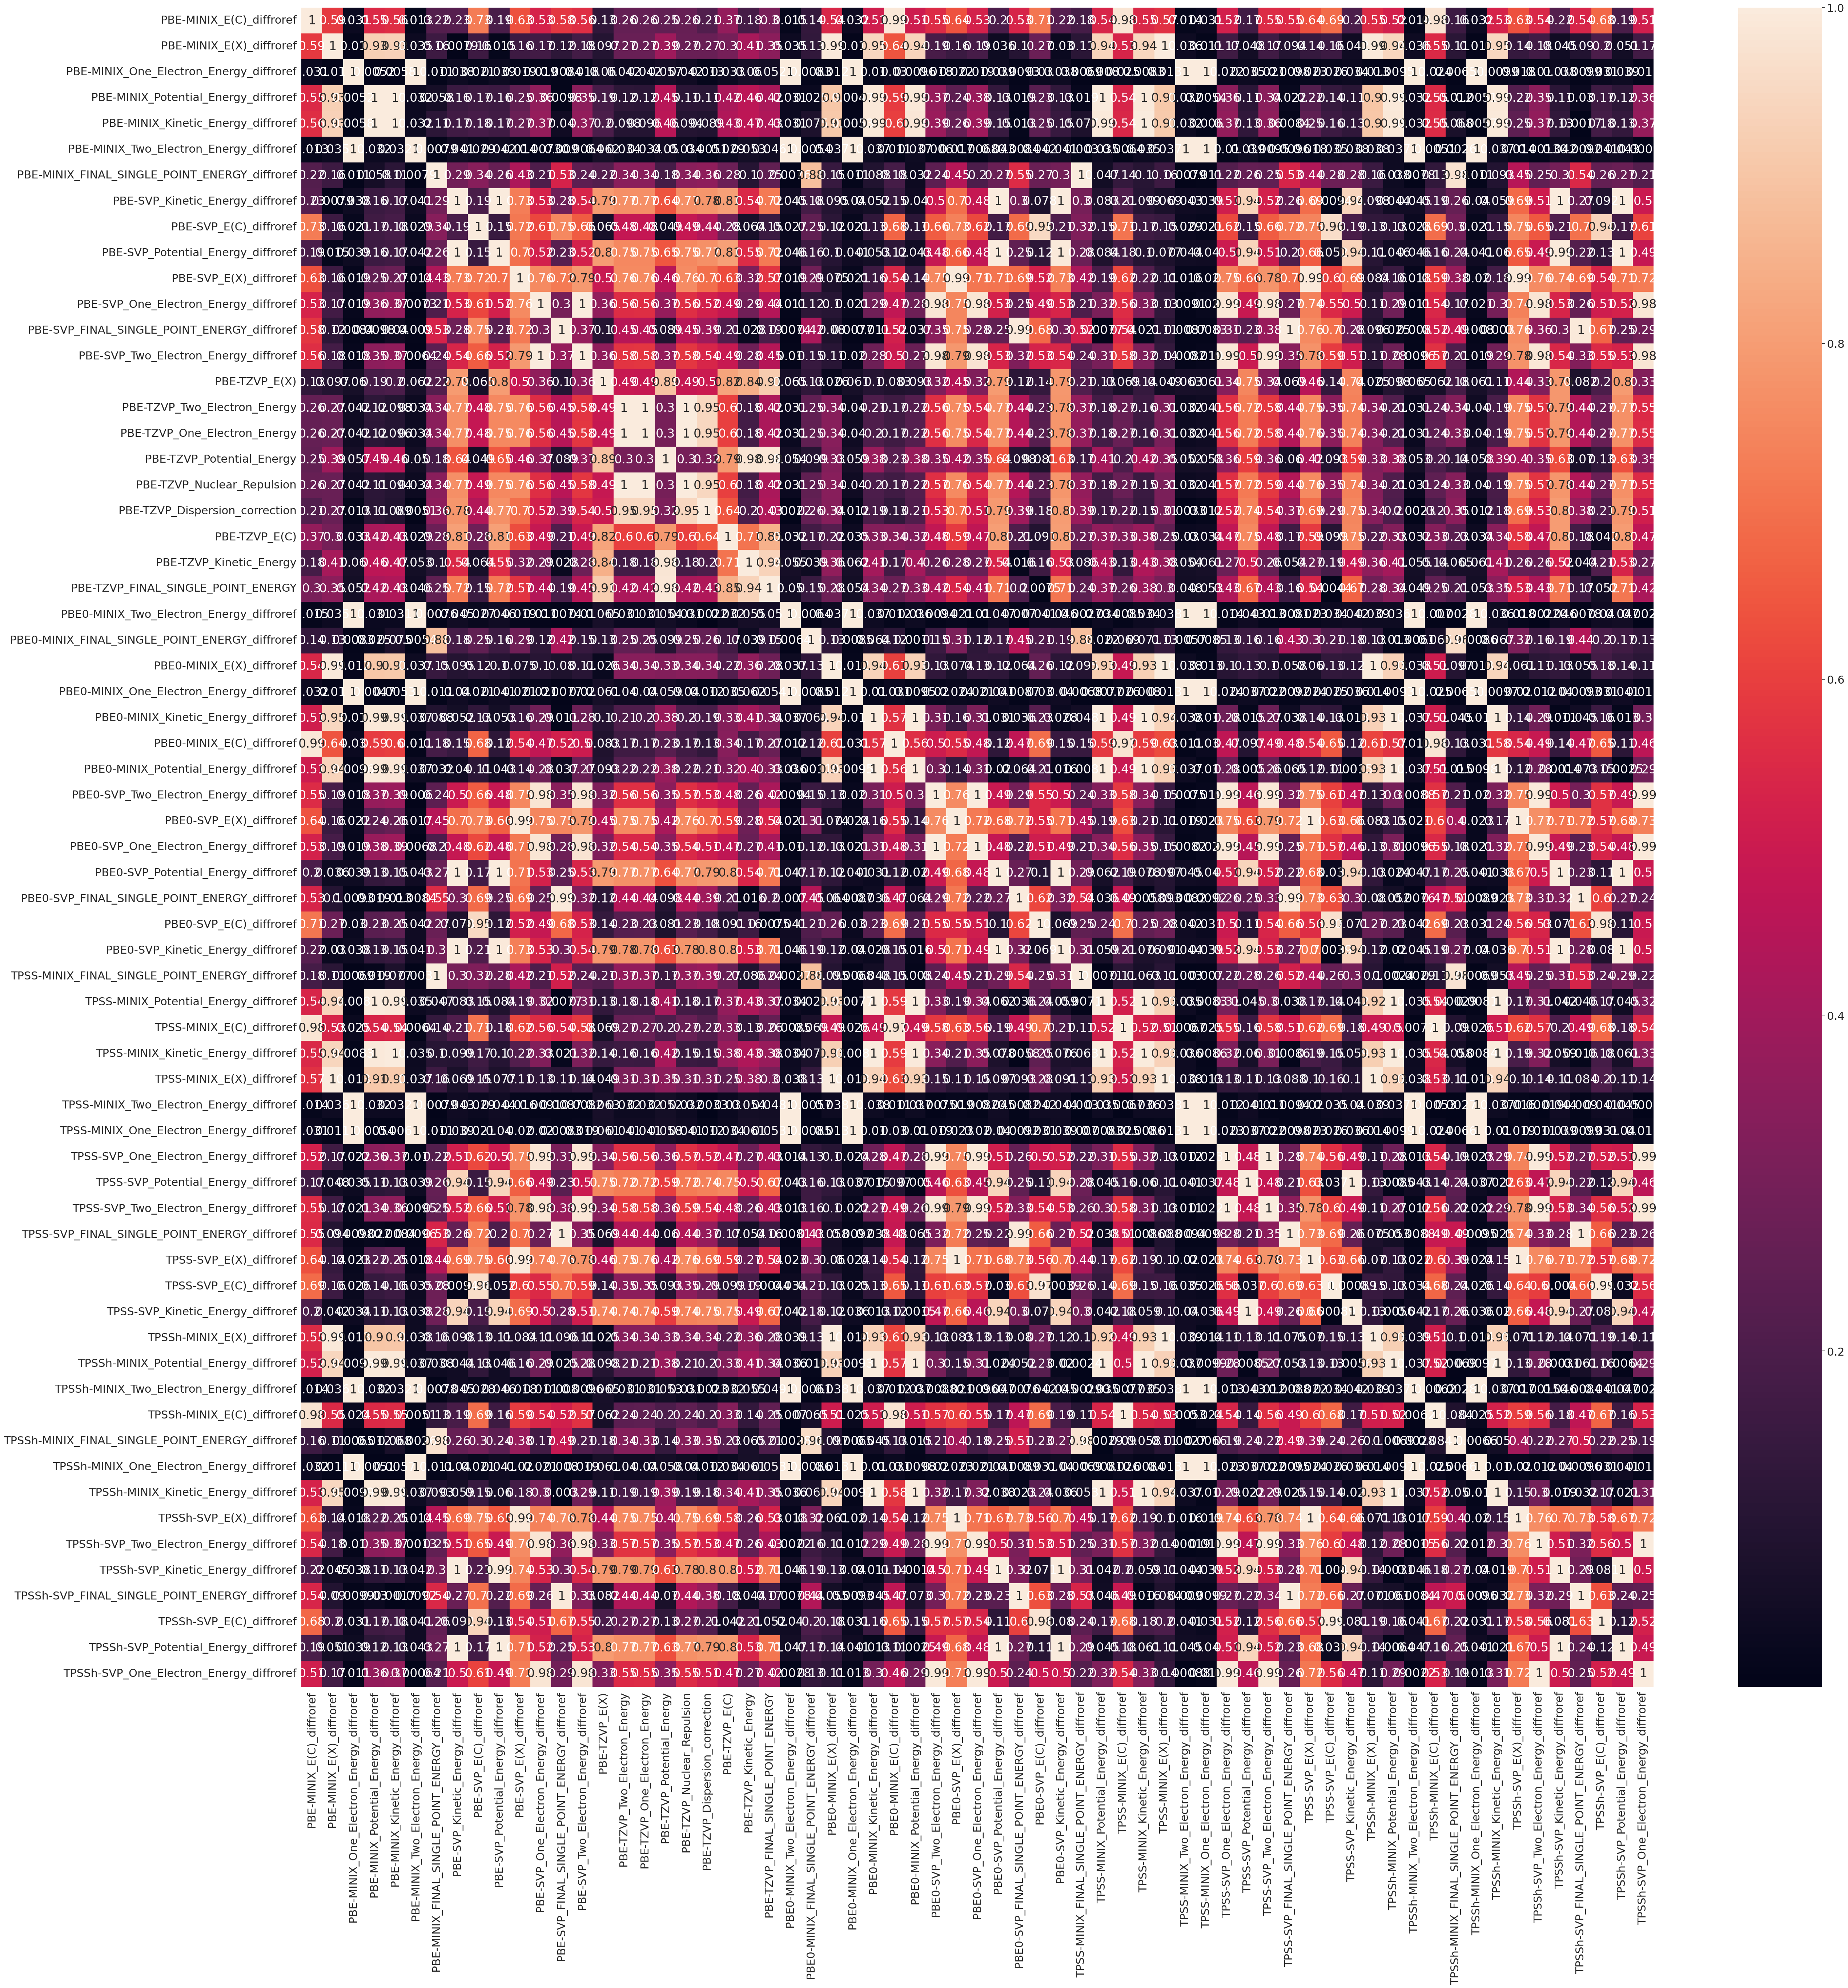

In [8]:
#for setname in fullsetnames:
#    print("Descriptors for ", setname)
#    i = 1
#    for k in models_results[setname].features:
#        print(i, " - ", k, len(models_results[setname].features[k]), \
#           models_results[setname].features[k])
#        i += 1

import seaborn as sns
%matplotlib inline

setname = "Full"
df = pd.DataFrame(models_results[setname].uncorrelated_features)
print("Correlation matrix")
plt.rcParams['figure.figsize'] = 60,60
sns.set(font_scale=2)
sns.heatmap(df.corr().abs(), annot=True)
#print(df.corr().abs())
#sns.heatmap(df, annot=True)

In [9]:
import importlib
importlib.reload(models)
importlib.reload(commonutils)

perc_split = 0.2
for setname in list(supersetnames)+["Full"]:
   print("Running PLS for dataset: ", setname)

   X, Y, features_names = \
      commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
              models_results[setname].labels)
   setlist = []
   for i, s in enumerate(models_results[setname].setnames):
        ss = models_results[setname].supersetnames[i]
        setlist.append(ss + "_" + s)   
   supersetlist = models_results[setname].supersetnames
   maxcomp = X.shape[1]
   ncomps, rmses, r2s, wtmads = \
          models.pls_model (perc_split, X, Y, supersetlist, setlist, \
          ncomp_start = 1, ncomp_max = maxcomp, split = False)
   r2max_comps = np.argmax(r2s)+1
   rmsemin_comps = np.argmin(rmses)+1
   wtmadmin_comps = np.argmin(wtmads)+1
   print("Best number of components for R2: ", r2max_comps)
   print("Best number of components for RMSE: ", rmsemin_comps)
   print("Best number of components for WTMAD: ", wtmadmin_comps)
   compstouse = wtmadmin_comps
   rmse_train, rmse_test, r2_train, \
      r2_test, rmse_full, r2_full , \
      models_results[setname].plsmodel, \
      X_train, X_test, y_train, y_test  = \
              models.pls_model (perc_split, X, Y, supersetlist, setlist, \
                                False, compstouse, split = False)
   
   models_results[setname].y_pred = \
      models_results[setname].plsmodel.predict(X) 

Running PLS for dataset:  BARRIER_HEIGHTS
Best number of components for R2:  64
Best number of components for RMSE:  64
Best number of components for WTMAD:  58
Running PLS for dataset:  INTRAMOLECULAR_INTERACTIONS
Best number of components for R2:  63
Best number of components for RMSE:  63
Best number of components for WTMAD:  44
Running PLS for dataset:  SMALL_MOLECULES
Best number of components for R2:  61
Best number of components for RMSE:  61
Best number of components for WTMAD:  48
Running PLS for dataset:  INTERMOLECULAR_INTERACTIONS
Best number of components for R2:  63
Best number of components for RMSE:  63
Best number of components for WTMAD:  44
Running PLS for dataset:  LARGE_SYSTEMS
Best number of components for R2:  64
Best number of components for RMSE:  64
Best number of components for WTMAD:  56
Running PLS for dataset:  Full
Best number of components for R2:  64
Best number of components for RMSE:  64
Best number of components for WTMAD:  18


In [10]:
print(" Dim , %40s"% "Dataset", " , ", \
      "Best inside method RMSE", " , ", \
      "Best our method RMSE", " , ", \
      "RMSE (superset) ," + \
      "RMSE (Full)")
pls_model_full = models_results["Full"].plsmodel
X, Y, features_names = \
    commonutils.build_XY_matrix (models_results["Full"].uncorrelated_features, \
                                    models_results["Full"].labels)
y_pred = pls_model_full.predict(X)
rmse = mean_squared_error(Y, y_pred, squared=False)
r2 = r2_score(Y, y_pred)
print("%4d , %40s"%(len(models_results["Full"].labels), "Full"), " , ", \
    "%7.3f"%models_results["Full"].bestinsidemethod_rmse, " , ", \
    "%7.3f"%models_results["Full"].bestourmethod_rmse, " , ", \
    "%7.3f"%rmse, " , ", \
    "%7.3f"%rmse)

for ssetname in supersetnames:
    pls_model_ssetname = models_results[ssetname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[ssetname].uncorrelated_features, \
                                    models_results[ssetname].labels)
    y_pred = pls_model_ssetname.predict(X)
    rmse = mean_squared_error(Y, y_pred, squared=False)

    y_pred_full = pls_model_full.predict(X) 
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)

    print("%4d , %40s"%(len(models_results[ssetname].labels), ssetname), " , ", \
        "%7.3f"%models_results[ssetname].bestinsidemethod_rmse, " , ", \
        "%7.3f"%models_results[ssetname].bestourmethod_rmse, " , ", \
        "%7.3f"%rmse, " , ", \
        "%7.3f"%rmse_full)
    
    for isetname in supersetnames[ssetname]:
        setname = ssetname + "_" + isetname 
        X, Y, features_names = \
            commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)

        y_pred_ssetname = pls_model_ssetname.predict(X)
        rmse_ssetname = mean_squared_error(Y, y_pred_ssetname, squared=False)

        y_pred_full = pls_model_full.predict(X)
        rmse_full = mean_squared_error(Y, y_pred_full, squared=False)

        print("%4d , %40s"%(len(models_results[setname].labels), setname), " , ", \
            "%7.3f"%models_results[setname].bestinsidemethod_rmse, " , ", \
            "%7.3f"%models_results[setname].bestourmethod_rmse, " , ", \
            "%7.3f"%rmse_ssetname, " , ", \
            "%7.3f"%rmse_full)


 Dim ,                                  Dataset  ,  Best inside method RMSE  ,  Best our method RMSE  ,  RMSE (superset) ,RMSE (Full)
1505 ,                                     Full  ,    9.227  ,    6.219  ,    5.508  ,    5.508
 194 ,                          BARRIER_HEIGHTS  ,    8.201  ,    4.856  ,    1.594  ,    5.237
  76 ,                     BARRIER_HEIGHTS_BH76  ,   10.387  ,    5.505  ,    1.770  ,    7.250
  10 ,                  BARRIER_HEIGHTS_BHDIV10  ,    9.191  ,    5.278  ,    2.326  ,    5.690
  26 ,                   BARRIER_HEIGHTS_BHPERI  ,    4.407  ,    3.762  ,    1.695  ,    2.770
  27 ,                  BARRIER_HEIGHTS_BHROT27  ,    0.611  ,    0.718  ,    1.260  ,    1.586
  24 ,                    BARRIER_HEIGHTS_INV24  ,    2.658  ,    1.534  ,    1.075  ,    5.068
  13 ,                     BARRIER_HEIGHTS_PX13  ,   11.730  ,    8.204  ,    1.332  ,    1.633
  18 ,                   BARRIER_HEIGHTS_WCPT18  ,    8.999  ,    5.887  ,    1.344  ,    2.159
 2

Results for  BARRIER_HEIGHTS
WTAMD2         (ssetname)   1.890
WTAMD2             (Full)   5.270
WTAMD2 (bestinsidemethod)   8.040
WTAMD2    (bestourmethod)   4.970
RMSE           (ssetname)   1.594
RMSE               (Full)   5.237
RMSE   (bestinsidemethod)   8.201
RMSE      (bestourmethod)   4.856


<Figure size 1000x1000 with 0 Axes>

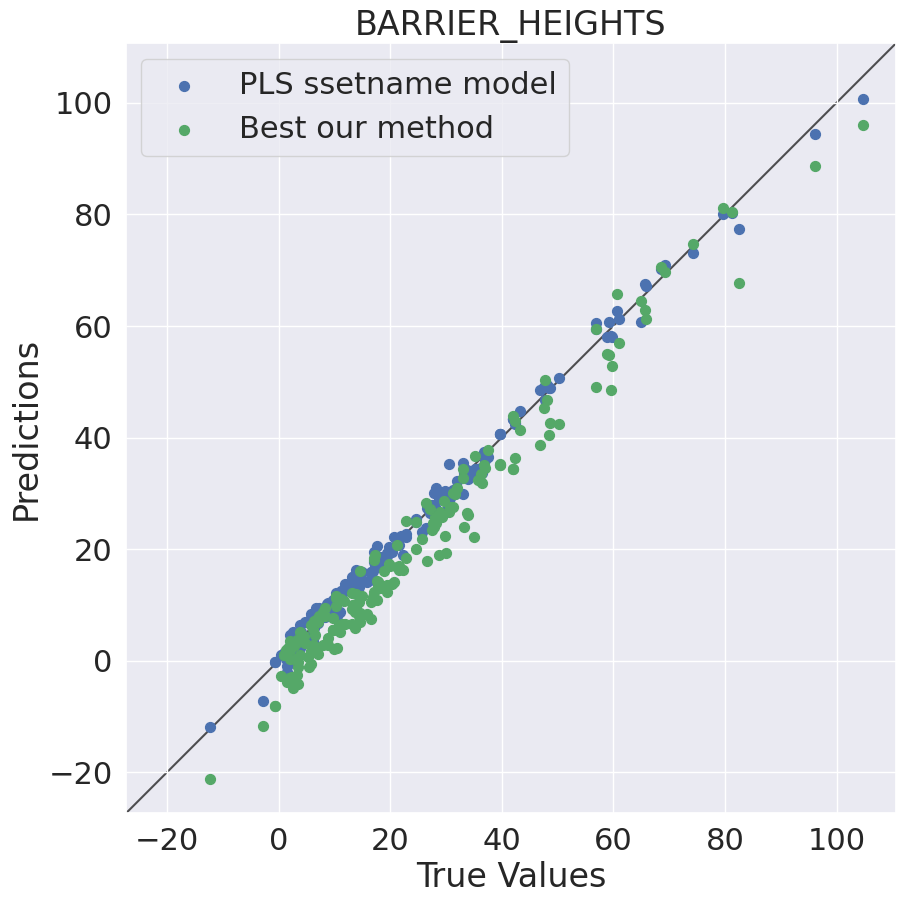

Results for  INTRAMOLECULAR_INTERACTIONS
WTAMD2         (ssetname)   0.300
WTAMD2             (Full)   0.990
WTAMD2 (bestinsidemethod)   0.690
WTAMD2    (bestourmethod)   0.640
RMSE           (ssetname)   0.262
RMSE               (Full)   0.951
RMSE   (bestinsidemethod)   0.873
RMSE      (bestourmethod)   0.589


<Figure size 1000x1000 with 0 Axes>

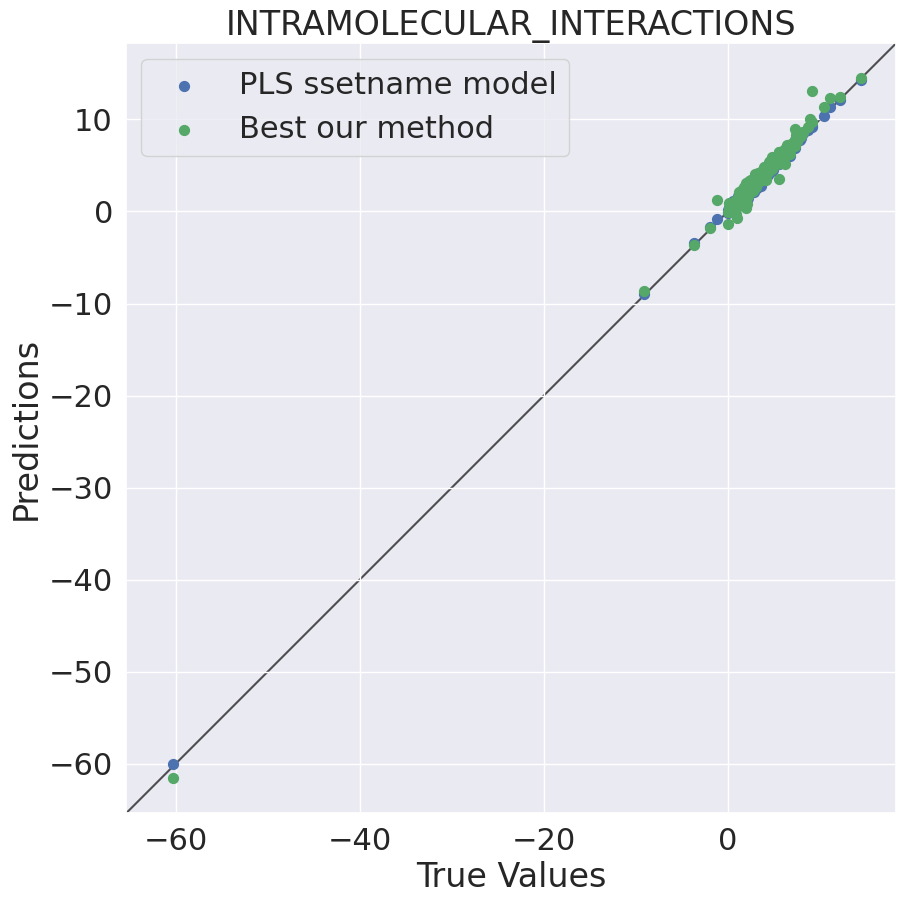

Results for  SMALL_MOLECULES
WTAMD2         (ssetname)   8.680
WTAMD2             (Full)  12.530
WTAMD2 (bestinsidemethod)  13.010
WTAMD2    (bestourmethod)  10.140
RMSE           (ssetname)   4.863
RMSE               (Full)   7.274
RMSE   (bestinsidemethod)  12.191
RMSE      (bestourmethod)   6.291


<Figure size 1000x1000 with 0 Axes>

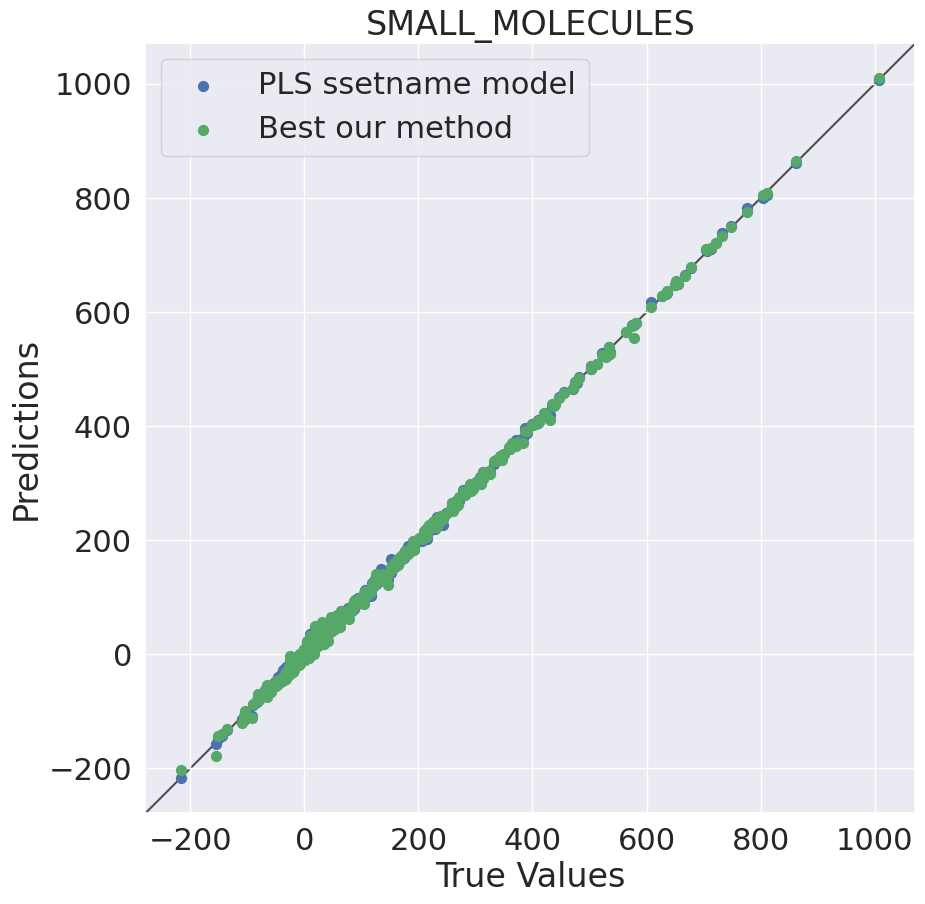

Results for  INTERMOLECULAR_INTERACTIONS
WTAMD2         (ssetname)   1.860
WTAMD2             (Full)   6.670
WTAMD2 (bestinsidemethod)   3.700
WTAMD2    (bestourmethod)   4.030
RMSE           (ssetname)   0.519
RMSE               (Full)   2.317
RMSE   (bestinsidemethod)   2.286
RMSE      (bestourmethod)   5.970


<Figure size 1000x1000 with 0 Axes>

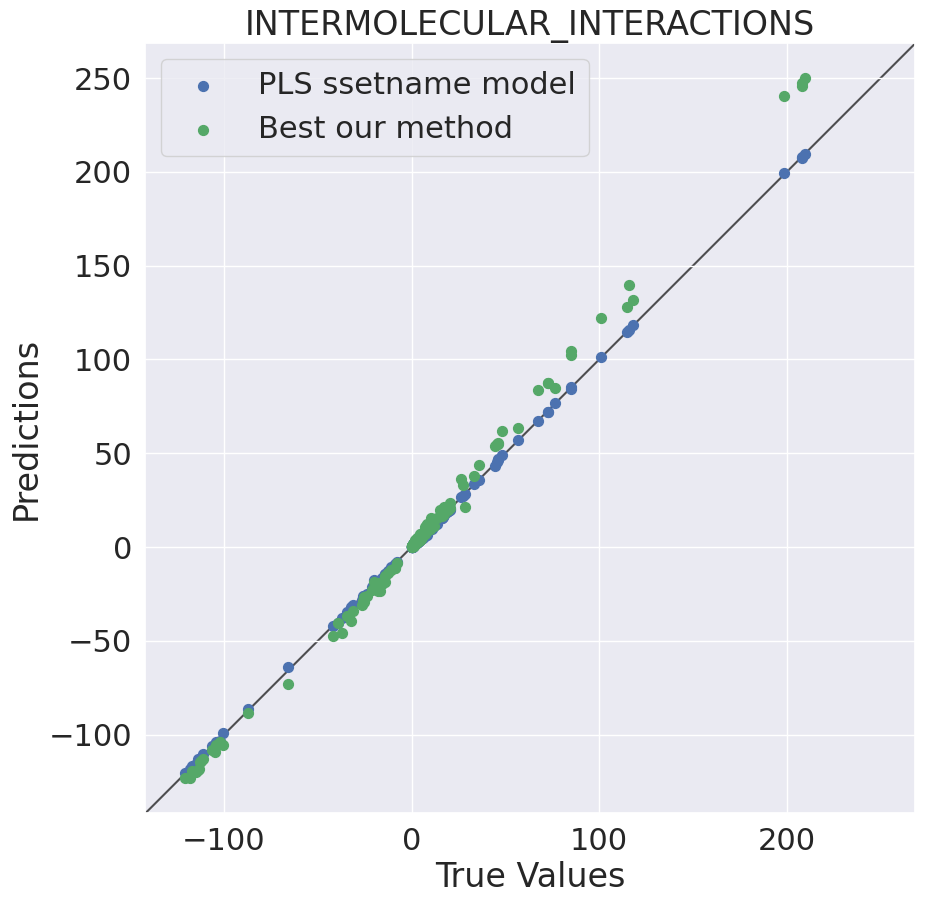

Results for  LARGE_SYSTEMS
WTAMD2         (ssetname)  10.790
WTAMD2             (Full)  14.560
WTAMD2 (bestinsidemethod)  16.050
WTAMD2    (bestourmethod)  11.330
RMSE           (ssetname)   2.512
RMSE               (Full)   7.429
RMSE   (bestinsidemethod)  12.567
RMSE      (bestourmethod)   9.042


<Figure size 1000x1000 with 0 Axes>

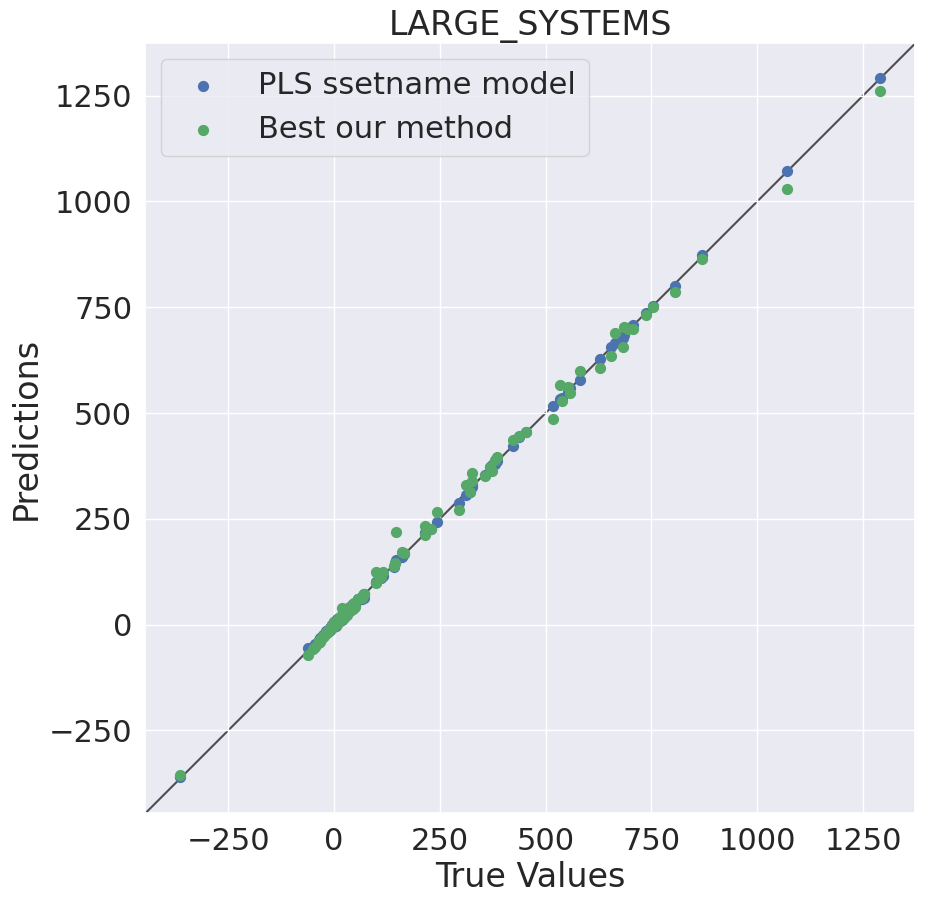

Results for Full
WTAMD2              (PLS)   4.980
WTAMD2 (bestinsidemethod)  10.160
WTAMD2    (bestourmethod)   8.170
RMSE                (PLS)   2.974
RMSE   (bestinsidemethod)   9.227
RMSE      (bestourmethod)   6.219


In [18]:
setname = "Full"
pls_model_full = models_results[setname].plsmodel
printonlysuperset = True
setnametouse = deepcopy(fullsetnames)
setnametouse.remove("Full")

ypredFull = []
supersetlistFull = []
setnamesFull = []

for setname in setnametouse:
    if setname in supersetnames:
        ssetname = setname  
    else:    
        lastunder = setname.rfind("_")
        ssetname = setname[:lastunder]
    
    pls_model_ssetname = models_results[ssetname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)
    setlist = []
    for i, s in enumerate(models_results[setname].setnames):
        ss = models_results[setname].supersetnames[i]
        setlist.append(ss + "_" + s)   
    supersetlist = models_results[setname].supersetnames
    
    y_pred_full = pls_model_full.predict(X)
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)

    y_pred = pls_model_ssetname.predict(X)
    rmse = mean_squared_error(Y, y_pred, squared=False)
    
    if setname in supersetnames:
        ypredFull.extend(y_pred)
        supersetlistFull.extend(supersetlist)
        setnamesFull.extend(setlist)
        print("Results for ", setname)
        wtmad2 = commonutils.wtmad_calc(supersetlist, setlist, y_pred, \
                                      Y, includeFull = True)
        wtmad2_full = commonutils.wtmad_calc(supersetlist, setlist, y_pred_full, \
                                      Y, includeFull = True)
        print("WTAMD2         (ssetname) %7.3f"%wtmad2["Full"])
        print("WTAMD2             (Full) %7.3f"%wtmad2_full["Full"])
        print("WTAMD2 (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_wtamd) 
        print("WTAMD2    (bestourmethod) %7.3f"%models_results[setname].bestourmethod_wtamd)
        
    if printonlysuperset and setname not in list(supersetnames.keys()) + ["Full"]:
        continue

    print("RMSE           (ssetname) %7.3f"%rmse)
    print("RMSE               (Full) %7.3f"%rmse_full,)
    print("RMSE   (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_rmse)
    print("RMSE      (bestourmethod) %7.3f"%models_results[setname].bestourmethod_rmse)
    
    plt.clf()
    plt.rcParams['figure.figsize'] = 10,10
    fig, ax = plt.subplots()
    ax.scatter(Y, y_pred, c='b', s=50, label='PLS ssetname model')
    #ax.scatter(Y, y_pred_full, c='y', s=50, label='PLS full model')
    #ax.scatter(Y, models_results[setname].y_pred_bestinsidemethod, \
    #            c='r', s=50, label='Best inside method')
    ax.scatter(Y, models_results[setname].y_pred_bestourmethod_rmse, \
               c='g', s=50, label='Best our method')
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend(loc="upper left")
    plt.title(setname)
    plt.show()

print("Results for Full")
X, Y, features_names = \
        commonutils.build_XY_matrix (models_results["Full"].uncorrelated_features, \
                                    models_results["Full"].labels)
wtmad2 = commonutils.wtmad_calc(supersetlistFull, setnamesFull, ypredFull, \
                              Y, includeFull = True)
print("WTAMD2              (PLS) %7.3f"%wtmad2["Full"])
print("WTAMD2 (bestinsidemethod) %7.3f"%models_results["Full"].bestinsidemethod_wtamd)
print("WTAMD2    (bestourmethod) %7.3f"%models_results["Full"].bestourmethod_wtamd)
rmse = mean_squared_error(models_results["Full"].labels, ypredFull, squared=False)
print("RMSE                (PLS) %7.3f"%rmse)
print("RMSE   (bestinsidemethod) %7.3f"%models_results["Full"].bestinsidemethod_rmse)
print("RMSE      (bestourmethod) %7.3f"%models_results["Full"].bestourmethod_rmse)


In [12]:
#test and dump PLS equations
setname = "Full"
pls_model_full = models_results[setname].plsmodel

for setname in fullsetnames:
    print("Equations for dataset: ", setname)
    ssetname = "Full"
    if setname in supersetnames or setname == "Full":
        ssetname = setname  
    else:    
        lastunder = setname.rfind("_")
        ssetname = setname[:lastunder]
    
    pls_model_ssetname = models_results[ssetname].plsmodel
    X, Y, features_names = \
        commonutils.build_XY_matrix (models_results[setname].uncorrelated_features, \
                                    models_results[setname].labels)
    
    y_pred_full = pls_model_full.predict(X)
    rmse_full = mean_squared_error(Y, y_pred_full, squared=False)
    r2_full = r2_score(Y, y_pred_full)
    X_e = X.copy()
    X_e -= pls_model_full._x_mean
    X_e /= pls_model_full._x_std
    y_pred_full_e = np.dot(X_e, pls_model_full.coef_.T)
    y_pred_full_e += pls_model_full._y_mean
    rmse_full_e = mean_squared_error(Y, y_pred_full_e, squared=False)
    print("   Full dataset equations Y mean %7.3f"%pls_model_full._y_mean)
    for i, f in enumerate(features_names):
        print(" %50s %7.3f [%15.3f %15.3f]"%(f, \
            pls_model_full.coef_.T[i],
            pls_model_full._x_mean[i], 
            pls_model_full._x_std[i]))

    y_pred = pls_model_ssetname.predict(X)
    rmse = mean_squared_error(Y, y_pred, squared=False)
    r2 = r2_score(Y, y_pred)
    X_e = X.copy()
    X_e -= pls_model_ssetname._x_mean
    X_e /= pls_model_ssetname._x_std
    y_pred_e = np.dot(X_e, pls_model_ssetname.coef_.T)
    y_pred_e += pls_model_ssetname._y_mean
    rmse_e = mean_squared_error(Y, y_pred_e, squared=False)
    for i, f in enumerate(features_names):
        print(" %50s %7.3f [%15.3f %15.3f]"%(f, \
            pls_model_ssetname.coef_.T[i],
            pls_model_ssetname._x_mean[i], 
            pls_model_ssetname._x_std[i]))

    print()
    print("RMSE         (ssetname) %7.3f from eq. %7.3f diff []"%(rmse, rmse_e))
    print("RMSE             (Full) %7.3f from eq. %7.3f diff []"%(rmse_full, rmse_full_e))  
    print("RMSE (bestinsidemethod) %7.3f"%models_results[setname].bestinsidemethod_rmse)
    print("RMSE    (bestourmethod) %7.3f"%models_results[setname].bestourmethod_rmse)
    print()


Equations for dataset:  BARRIER_HEIGHTS
   Full dataset equations Y mean  61.604
                           PBE-MINIX_E(C)_diffroref  -1.474 [          0.288           2.495]
                           PBE-MINIX_E(X)_diffroref  -1.392 [         11.015          96.114]
            PBE-MINIX_One_Electron_Energy_diffroref  -0.360 [       3326.710       18818.073]
               PBE-MINIX_Potential_Energy_diffroref  -5.134 [         92.172         564.130]
                 PBE-MINIX_Kinetic_Energy_diffroref   5.337 [        -92.341         566.936]
            PBE-MINIX_Two_Electron_Energy_diffroref   0.154 [      -1680.625        9427.270]
      PBE-MINIX_FINAL_SINGLE_POINT_ENERGY_diffroref   3.983 [         -0.169          32.537]
                   PBE-SVP_Kinetic_Energy_diffroref   3.555 [        -41.274         146.049]
                             PBE-SVP_E(C)_diffroref  -5.566 [          0.145           1.746]
                 PBE-SVP_Potential_Energy_diffroref  -3.541 [         40.